# Support Vector Machine (SVM) Model

## Data Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict


# Set working directory
month_file = '6_October'

os.chdir("/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/"+month_file+"/Ending Balances/Per_Player")

In [2]:
# Filter Columns
filter = ['session_time', 'gender', 'age_gen', 'day', 'timeofday', 'first_outcome',
        'first_wager','first_p/b', 'last_outcome', 'last_wager', 'last_p/b',
        'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom', 
        'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
        'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
        'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit', 'depletion_slope', 
        '#inc_slotdenom', '#dec_slotdenom', '#inc_maxbet', '#dec_maxbet',
        'w/min', 'l/min', 'nh/min', 'd/min', '2ws_profit', '2ws_wgramt','2ws/min', 
        '3ws_profit', '3ws_wgramt', '3ws/min', '4ws_profit', '4ws_wgramt', '4ws/min', 
        'w/g', 'l/g', 'nh/g', 'd/g', 'ave_time_per_gamble',
        'min_time_per_gamble', 'machines_changes', 'unique_machines', 'classification']

# Load dataset
dataset = pd.read_parquet('top_vs_ntop_player_ending_balance_by_session.parquet', columns=filter)

# Keep only session_time 1
dataset = dataset[dataset['session_time'] == 1]
# Drop age_range and playerkey
dataset = dataset.drop(['session_time'], axis=1)

## Load Dataframes

In [3]:
# Convert 'ave_time_per_machine' to seconds

# # Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Econde gender column (Binary)
le = LabelEncoder()

# Binary Encode gender and simplay
X[:, 0] = le.fit_transform(X[:, 0])

# # Encode age_generartion, day, time of day,  and time of day columns, first_outcome, and last_outcome.
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

y = le.fit_transform(y)

## Handling Class Imbalance 
# Apply SMOTE - SMOTE generates synthetic samples for the minority class to balance the dataset:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size = 0.2, random_state = 1)

sc = StandardScaler()

# Scale all columns except the encoded ones
X_train[:, 25:] = sc.fit_transform(X_train[:, 25:])
X_test[:, 25:] = sc.transform(X_test[:, 25:])

classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))

[[879 135]
 [150 812]]
Accuracy:  0.8557692307692307
Precision:  0.8558359835109184
Recall:  0.855469374700144
F1 Score:  0.8556032211589126


## Cumulative Accuracy Profile (CAP) Graph

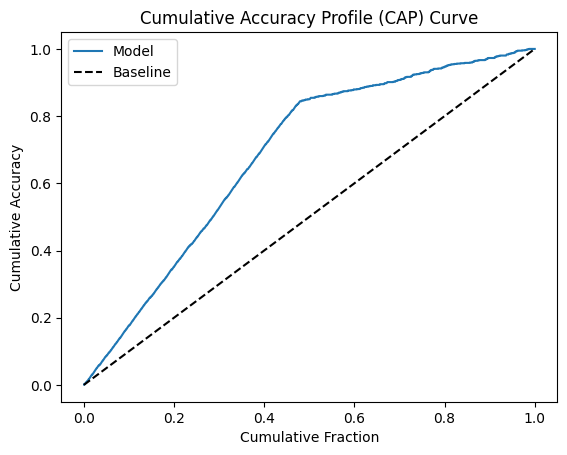

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred)[::-1]
sorted_true_labels = y_test[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_test)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [5]:
# Define the SVM hyperparameters and their respective ranges
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel type
}

# Create an SVM classifier
svm_classifier = SVC(random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the data to perform the search
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

# Print the best hyperparameters
print('Best Hyperparameters:', best_params)

Confusion Matrix:
[[935  79]
 [ 56 906]]
Accuracy: 0.9316801619433198
Precision: 0.931644188559984
Recall: 0.9319393357854897
F1 Score: 0.9316654434791296
Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}


## Cross Validation

In [6]:
# Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Encode gender column (Binary)
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# Encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)

# Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled[:, 25:] = sc.fit_transform(X_resampled[:, 25:])

# Best hyperparameters from tuning
best_hyperparameters = best_params

# Initialize logistic regression model with best hyperparameters
classifier = SVC(random_state=0, **best_hyperparameters)

# Perform cross-validation
y_pred_cv = cross_val_predict(classifier, X_resampled, y_resampled, cv=10, n_jobs=-1)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(classifier, X_resampled, y_resampled, cv=10, scoring='accuracy', n_jobs=-1 )
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

# Calculate precision, recall, and F1-score
precision = precision_score(y_resampled, y_pred_cv, average='macro')
recall = recall_score(y_resampled, y_pred_cv, average='macro')
f1 = f1_score(y_resampled, y_pred_cv, average='macro')

# Print the metricsvr
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_pred_cv)
print("Confusion Matrix:")
print(conf_matrix)

Cross-Validation Scores: [0.89676113 0.90283401 0.91194332 0.92813765 0.93117409 0.9159919
 0.92510121 0.92813765 0.9260385  0.93718338]
Mean Accuracy: 0.92033028561584
Standard Deviation of Accuracy: 0.012367933644890422
Precision: 0.9212655414473108
Recall: 0.920328001619761
F1 Score: 0.920283648802594
Confusion Matrix:
[[4429  510]
 [ 277 4662]]


In [7]:
results = ['Random Forest', mean_accuracy, std_accuracy, precision, recall, f1]
columns = ['Model', 'Mean Accuracy', 'Std of Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df = pd.DataFrame([results], columns=columns)

# Print the results as a LaTeX table
latex_table = results_df.to_latex(index=False, escape=False)
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
        Model &  Mean Accuracy &  Std of Accuracy &  Precision &   Recall &  F1 Score \\
\midrule
Random Forest &        0.92033 &         0.012368 &   0.921266 & 0.920328 &  0.920284 \\
\bottomrule
\end{tabular}



/var/folders/vp/1skwx2kd29s4fxnxx7tt9r6w0000gn/T/ipykernel_3965/3783961505.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = results_df.to_latex(index=False, escape=False)


Text(0.5, 1.0, 'Cumulative Accuracy Profile (CAP) Curve')

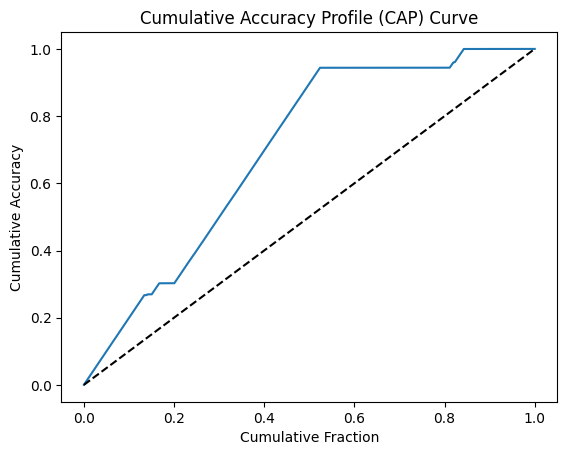

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred_cv)[::-1]
sorted_true_labels = y_resampled[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_resampled)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')

## Feature Importance

In [9]:
# drop last column
dataset= dataset.drop(['classification'], axis=1)

# Initialize logistic regression model {USING LINEAR instad of rbf}
classifier = SVC(random_state=0, C=10, kernel='linear')

# Fit the logistic regression model
classifier.fit(X_train, y_train)

# Modify the get_feature_names_out function to exclude 'remainder__'
def get_feature_names_without_prefix(transformer, input_features=None):
    return [f.split('remainder__')[-1] for f in transformer.get_feature_names_out(input_features)]

# Get the feature names without 'remainder__' prefix
feature_names = get_feature_names_without_prefix(ct, input_features=dataset.columns)

# Get the coefficients and feature names
coefficients = classifier.coef_[0]

# Create a DataFrame to display coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by magnitude
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print the feature names and coefficients
print("Top features and their coefficients:")
print(coefficients_df.head(5))


Top features and their coefficients:
       Feature  Coefficient  Abs_Coefficient
44     std_p/b    -7.713217         7.713217
45     max_p/b     6.868250         6.868250
56  2ws_profit     6.593471         6.593471
57  2ws_wgramt     4.419179         4.419179
43     ave_p/b     2.988923         2.988923
